<div align="right"><i>COM418 - Computers and Music</i></div>
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

<p style="font-size: 30pt; font-weight: bold; color: #B51F1F;">Measuring Sound </p>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython

import matplotlib
plt.rcParams["figure.figsize"] = (14,4)

In [2]:
def analog_response(b, a, sf, dB=-70, half=True, points=8000, axis=None, color='C0'):
    """plot the magnitude response of a digital filter on a log-log scale"""
    F0 = 10
    EPS = 1e-20
    w = np.linspace(2 * np.pi * F0 / sf, np.pi, points)
    A, B = np.zeros(points, dtype='complex'), np.zeros(points, dtype='complex')
    for n, bn in enumerate(b):
        B += bn * np.exp(-1j * n * w)
    for n, an in enumerate(a):
        A += an * np.exp(-1j * n * w)
    M = 20 * np.log10(np.abs(np.where(B == 0, EPS, B) / (np.where(A == 0, EPS, A))))
    
    if axis is None:
        _, axis = plt.subplots()
    axis.plot(np.linspace(F0, sf / 2, points), M, color, lw=2)
    axis.set_xscale('log')
    axis.set_ylabel('dB', color='C0')
    axis.grid(b=True, which='both')    
    axis.axis('tight')
    axis.set_ylim([max(dB, min(M)), None])    

In [3]:
# we will need some real-world audio for some samples. 
from IPython.display import Audio
from scipy.io import wavfile

# Brandenburg concerto #1, mono, 8 kHz
audio_sample_sf, audio_sample = wavfile.read("snd/brand1.wav")
audio_sample = audio_sample / 32767.0

# The many incarnations of sound

Sound: a vibration that propagates through a medium as an acoustic wave (more on this later)

The information carried by a sound can be encoded in many forms:
 
 * as a pressure wave $p(t)$ in air or other elastic medium with amplitude measured in pascal (this is what we can hear with our ears)
 * as an electric signal $v(t)$ as produced by, say, a microphone and measured in volts
 * as a groove depth $g(x)$ in a vinyl record
 * as a space-varying magnetic field on a tape coated with ferromagnetic particles 
 * as a discrete-time signal $x[n]$, stored as a sequence of integer values in digital memory
 
These alternate representations are at least in principle equivalent and can be converted into one another via the appropriate devices.

## Measuring sound

Sound is a multi-faceted phenomenon:
 * time duration
 * amplitude variations
 * frequency content
 
Here, we are interested in a variety of quantitative metrics that are useful in audio recording and production

## Physical vs perceptual metrics

 * physical metrics are based on the intrinsic properties of a signal, independently of its nature
 * perceptual metrics take into account the human auditory system
 
Examples:
 * perceived loudness is related to power, but in very complicated ways
 * energy outside of human hearing range (20 Hz to 20 kHz) is irrelevant in perceptual metrics

# Common signal metrics

Given a continous- or discrete-time signal, we are interested in quantitative metrics that help us describe:

  * the presence of DC bias (balance)
  * the amplitude excursion (dynamic range)
  * the power at different time scales (related to loudness)

## Average (DC value)

$$
    \bar{x} \triangleq \frac{1}{T}\int_0^T x(t) dt \quad \triangleq \frac{1}{N}\sum_{n=0}^{N-1} x[n]
$$

In general, audio signals are zero-mean, that is, the distribution of their amplitude values is balanced around zero. 

If this is not the case, we say that the signal has a _DC bias_ ; this is bad because:
 * it needlessly reduced the _input_ dynamic range (problems with recording, AD conversion, etc)
 * it reduces the _output_ dynamic range (speakers should oscillate around rest position)
 * it wastes energy in reproduction

## Peak amplitude and peak-to-peak

The maximum excursion in amplitude of a (zero-mean) sound signal $x(t)$ is called its **peak amplitude**

$$
    x_\mathrm{peak} \triangleq \max_t |x(t)| \quad \triangleq \max_n |x[n]|
$$

Peak-to-peak (p-p) can be used for asymmetric signals

$$
    x_\mathrm{p-p} \triangleq \max_t x(t) - \min_t x(t) 
$$

## True peak (digital signals)

The peak value of a discrete-time signals and that of its continuous-time version may not coincide; in these cases we refer to the continuous-time peak value as the **true peak**.  

For example take $x(t) = \cos(2\pi f + \pi / 4)$:
 * $x_\mathrm{peak} = 1$ independently of $f$
 * sample at $F_s = 4f$ to obtain $y[n] = x(n/F_s) = \cos(\pi n / 2 + \pi / 4)$
 * $y_\mathrm{peak} = 1/\sqrt{2}$
 * $20\log_{10}(y_\mathrm{peak}/x_\mathrm{peak}) = -3~\mathrm{dB}$

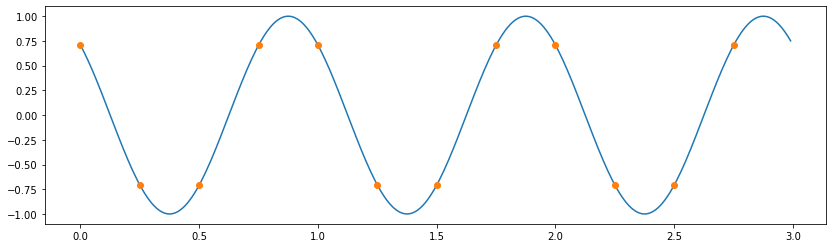

In [4]:
def x(t):
    return np.cos(np.pi/4 + 2 * np.pi * t)

t = np.arange(0, 3, 0.01)
plt.plot(t, x(t));
plt.plot(t[::25], x(t[::25]), 'o');

Question: what is the maximum possible gap between the discrete-time peak value and the true peak?

## Root Mean Square (RMS)

Many properties of a sound signal correlate more closely to the _power_ of the signal rather than to its max amplitude. 

Key concepts:
  * power is energy over time: **always associated to a time window**
  * power of a sound _source_ not the same as _measured_ power (decays as $1/r^2$)

The root-mean-square (RMS) value of a signal is defined as
 

$$
    x_{\mathrm{RMS}} \triangleq \sqrt{\frac{1}{T}\int_{0}^{T} |x(t)|^2 dt} \quad \triangleq \sqrt{\frac{1}{N}\sum_{n=0}^{N-1} |x[n]|^2}.
$$

Assume $x(t)$ is measured in Volts and the RMS analysis window is $T$ seconds:
 * $x_{\mathrm{RMS}}$ is the equivalent DC value that provides the same power as $x(t)$ to a resistive load
 * $(x_{\mathrm{RMS}})^2$ is the power of the signal to a $1~\Omega$ resistive load 
 * short window:  $x_{\mathrm{RMS}} \rightarrow x_\mathrm{peak}$ (peak power)

Caution: you will sometimes see this formula:

$$
    x_{\mathrm{RMS}} = \frac{x_\mathrm{peak}}{\sqrt{2}}
$$

**this is only true for pure sinusoids**

## Crest factor and peak-to-average power ratio (PAPR)

$$
    C = \frac{x_\mathrm{peak}}{x_\mathrm{RMS}}
$$

$$
    \mbox{PAPR} = C^2
$$

## Notable waveforms
<img src="img/waveforms.png" alt="wikipedia" style="width: 600px;"/>


## Relation to mathematical norms

When looking at signals as vectors:

 * $x_\mathrm{peak} = \| \mathbf{x} \|_\infty$
 * $x_\mathrm{RMS} = \| \mathbf{x} \|_2$

## Example

In [5]:
def metrics(x, axis=None):
    n_max, n_min = np.argmax(x), np.argmin(x)
    n_peak = n_max if np.abs(x[n_max]) > np.abs(x[n_min]) else n_min
    dc, rms = np.mean(x), np.sqrt(np.mean(x ** 2))
    m = {
        "DC": dc, 
        "peak_location": n_peak,
        "peak": x[n_peak],
        "p-p": x[n_max] - x[n_min],
        "RMS": rms
    }
    if axis is not None:
        axis.plot(x, color='lightgray', linewidth=0.5)
        axis.axhline(y=dc, color='C2', label=f"DC: {dc:.3f}")    
        axis.axhline(y=rms, color='C3', label=f"RMS: {rms:.3f}")    
        axis.plot((n_peak, n_peak), (dc, x[n_peak]), color='C0', label=f"peak = {x[n_peak]:.3f}")
        axis.axhline(y=x[n_max], color='C4') 
        axis.axhline(y=x[n_min], color='C4')
        axis.plot((0, 0), (x[n_max], x[n_min]), color='C4', label=f"p-p = {(x[n_max] - x[n_min]):.3f}")
        axis.plot(0, 0, linewidth=0, label=f'PAPR: {20 * np.log10(np.abs(x[n_peak])/rms):.2f} dB')
        axis.grid()
        axis.legend(loc='lower right')
    return m

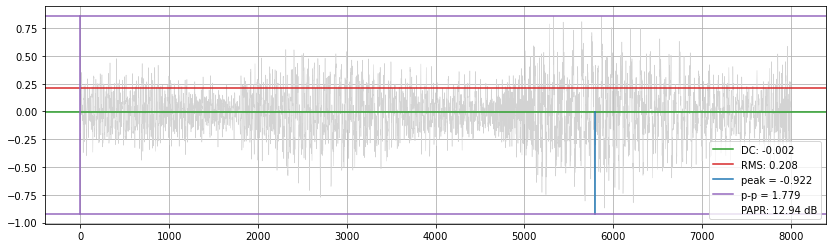

In [6]:
metrics(audio_sample[8000:16000], plt.subplots()[1]);

# Refresher: the decibel (dB)

Historically, a logarithmic measure of **power loss** over telecommunication cables. One dB was the average power loss over 1 mile of cable.

## Measuring power ratios

In general, for a power quantity $P$ and a _reference_ power $P_0$, 

$$
    L_P = 10\log_{10}\frac{P}{P_0}
$$

 * always relative to a reference value
 * positive for gain, negative for loss
 * +3 dB = twice the power
 * -3 dB = half the power
 * +10 dB = ten times the power
 
To go back to linear units (Watts)

$$
    P = P_0 \cdot 10^{L_P/10}
$$

## Measuring amplitude ratios

In most engineering applications, energy or power are proportional to the square of an amplitude value: $P \propto v^2$; some examples:
 * $P = V^2/R$ in electrical circuits
 * $E = mv^2/2$ for the kinetic energy
 * $I = p^2/Z$ for sound intensity. 
 

For amplitude ratios:

$$
    L_F = 10\log_{10}\frac{P}{P_0} = 10\log_{10}\frac{v^2}{v_0^2} = 20\log_{10}\frac{v}{v_0}
$$

 * +6 dB = twice the value
 * -6 dB = half the value
 * +20 dB = ten times the value
 
To go back to linear units

$$
    v = v_0 \cdot 10^{L_P/20}
$$

## Specialized units

  * **dBm** : power ratio with reference $P_0 = 1~\mathrm{mW}$
  * **dBu** : voltage (RMS) ratio with reference $v_0 = 0.7746~\mathrm{V}$ ($v_0$ is the voltage drop across a $600~\Omega$ resistor dissipating $1~\mathrm{mW}$; so, numerically, dBu = dBm)
  * **dBV** : voltage (RMS) ratio with reference $v_0 = 1~\mathrm{V}$ (dBV = dBu + 2.2)
  * **dBFS**: _peak_ amplitude ratio for digital signals at $R$ bps with reference $v_0 = 2^R$; always negative.
  

**Example: mic and Line levels:**

 * mic level: between -60 and -40 dBu (~1 mV RMS)
 * line level (consumer): 4 dBu (~1 V RMS) 
 * line level (pro): -10 dBV (-7.8 dBu, ~0.3 V RMS)

# Physical audio measurements

## What is sound? (again)

Sound: a vibration that propagates through a medium as an acoustic wave. Key terms:

 * vibration: displacement around an equilibrium point
 * acoustic wave (idealized): energy propagation without heat or mass changes (adiabatic)

### The acoustic wave

<img src="img/wave.gif" alt="https://www.acs.psu.edu/drussell/Demos/phase-p-u/phase-p-u.html" style="float: right; width: 400px; margin: 20px 30px;"/>

The initial displacement is caused by a **force** acting on the medium. This creates a **pressure** measured in pascals ($1~\mathrm{Pa} = 1~\mathrm{N/m^2}$)

The pressure causes particles in the medium to move around their equilibrium point with a (putative) **particle velocity** $\nu$

Interaction between neighboring particles creates an energy wave whose **propagations speed** $c$ (in $\mathrm{m/s}$) depends on the properties of the medium 

Importantly, particle velocity and propagation speed are not the same thing!

In general, we are interested in sound that:
  
 * propagates in air $\rightarrow$ $c \approx 343~\mathrm{m/s}$
 * is audible $\rightarrow$ frequency content between $16~\mathrm{Hz}$ and $20~\mathrm{kHz}$

## Amplitude measures

### Sound Pressure

Sound propagation in air on earth takes place via a time-varying deviation from the **atmospheric pressure** (i.e. the weight of the air in the atmosphere due to earth's gravitational pull; on average this pressure is $101,325~\mathrm{Pa}$, a value also known as 1 atmosphere). **Sound pressure** is the scalar value of the deviation from atmospheric pressure at the point of measurement.

 * The smallest sound pressure value detecteble by the human ear is called the **threshold of hearing** and it is conventionally defined as $p_0 = 20~\mu \mathrm{Pa} = 20 \cdot 10^{-6}~\mathrm{Pa}$ 
 * The (theoretical) loudest sound possible on earth would cause the local pressure to drop to zero, for a sound pressure value equal to 1 atmosphere.
 * sound pressure is _related_ to a subjective loudness "scale", but in complicated ways

### SPL

The softest and loudest sounds are separated by 11 orders of magnitude in pressure amplitude so it's customary to use a log scale. The **sound pressure level (SPL)** is defined as the difference in decibels between the pressure level at the point of measurement and the threshold of hearing:

$$
    L_p = 20\log_{10}\frac{p}{p_0}
$$

 * $1~\mathrm{Pa} = 94~\mathrm{dB~SPL}$
 * SPLs over $120~\mathrm{dB}$ can quickly provoke permanent hearing loss.
 * a particle of free air exposed to a sinusoidal sound pressure of $1~\mathrm{Pa}$ moves back and forth with a velocity amplitude of about $2~\mathrm{mm/s}$.

<img src="img/spl.png" alt="wikipedia" style="width: 600px;"/>


Question: what is the SPL of the loudest possible sound?

### Microphones

<img src="img/mic.jpg" alt="mic" style="float: right; width: 150px; margin: 10px 30px;"/>

Microphones convert _pressure_ levels to voltage levels.

Key ratings are **sensitivity**, measured in dBV/Pa or mV/Pa, and max SPL (after which the mic distorts). High-sensitivity mics are called "hot" (they quickly overload preamp stages)

| | | |
|--|--|--|
|Shure SM58 | –54.5 dBV/Pa (1.85 mV/Pa) | 150 dB |
|Royer R-121 | -47 dBV/Pa (4.5 mV/Pa) | 135 dB|


### Headphones

<img src="img/headphones.jpg" alt="headphones" style="float: right; width: 250px;"/>

What is the SPL generated by your headphones? It depends on your volume settings! Comfortable level: 60 to 80 dB SPL

Headphones are rated in terms of **sensitivity**, measured in SPL/V or SPL/mW. High sensitivity: less power to achieve target SPL but more fragile design

| | |
|--|--|
|Sennheiser HD 820 | 103 dB/V(RMS) @ 1 kHz |
|Apple Earpods | 117.96 dB/V| 



## Energy measures

### The acoustic impedance

Every medium that transmits sound has a certain "resistance" to wave propagation; this is called the medium's **acoustic impedance** $Z = \rho c$
 * $\rho$ is the medium density ($kg/m^3$)
 * $c$ is the speed of sound in the medium ($m/s$)
 * both $\rho$ and $c$ depend on temperature and frequency
 * $Z$ is measured in Rayls (Ry). ie. $Ns/m^3$

Examples:
 * air: $Z \approx 400~\mathrm{Ry}$
 * water: $Z \approx 1.48\cdot 10^6~\mathrm{Ry}$
 * steel: $Z \approx 45\cdot 10^6~\mathrm{Ry}$

Particle velocity and pressure are related as $\nu = p/Z$. Consequences:
 * for the same pressure, air particles move a lot more than water particles
 * at the interface between different materials: impedance mismatch

### Sound Intensity

Sound intensity measures the average rate of flow of energy through a unit area normal to the direction of wave propagation ($W/m^2$). It is a **vector** measurement that relates the scalar pressure value to the vector particle velocity across the point of measurement: 

$$ 
    \mathbf{I} = p \boldsymbol{\nu}
$$

Sound intensity is not directly relevant to audio applications since both microphones and human ears are sensitive to pressure. But it's an important measure because:
 
 * it shows the way sound pressure propagates in space (where to place microphones)
 * it accounts for the differences in propagation medium

Recall $\nu = p/Z$; then $I = p^2/Z$, which relates intensity to pressure (on an **averaged** scalar level). 

More generally, sound pressure and sound intensity are related by the acoustic equivalent of Ohm's law:

 * pressure is akin to voltage
 * particle velocity is akin to current
 * acoustic impedance is akin to resistance
 * intensity is akin to power
 
With this $v=Ri$ becomes $p = Z\nu$ and $W = vi=v^2/R$ becomes $I = p^2/Z$.

### SIL

As for pressure, the large dynamic range of occurring intensities leads to a logarithmic scale; the **sound intensity level (SIL)** is defined as the difference in decibels between the measurend intensity and a reference value of $1~pW/m^2$ 

$$
    L_I = 10\log_{10}\frac{I}{I_0}
$$

Note that intensity is a power measure, hence the factor of $10$ before the log. Since $I \propto p^2$, with the above choice for $I_0$ SPL and SIL coincide:

$$
    L_I = L_p
$$

### Multiple sources

Intensities of multiple sources combine additively as *vectors*. In terms of averaged magnitude it's... complicated; the result depends on
 * type of waveforms (planar, spherical)
 * phase coherence
 * sound field (diffuse, reverberant, etc)

Simplified approach: assume each source is independent white noise:
 * $I_\mathrm{total} = \sum_n I_n$
 * $N$ equal sources: $I_\mathrm{total} = NI$, so $L_\mathrm{total} = L_I + 10\log_10 N$
 * 2 sources: +3 dB
 * 10 sources: +10 dB (twice as **loud**...)


# Perceptual audio measurements

We are primarily concerned with **loudness**, which is is the _subjective_ perception of sound pressure; it is _related_ to SPL, to the frequency content and to the duration of a sound. Complicated! 

## Loudness (for sinusoidal test signals)

<img src="img/loudness.gif" alt="loudness" style="float: right; width: 600px; margin: 20px 30px;"/>


### Equal Loudness curves

Experiment: generate a 1 KHz sinusoid at $L_p$ SPL; change the frequency and ask the subject to adjust the "volume" (i.e. the SPL) to match the original tone. For every $L_p$ value, we obtain an equal-loudness curve as shown in the plot:

 * relation of loudness to SPL (or SIL) highly frequency-dependent
 * low sensitivity to low frequencies
 * maximum sensitivity between 3 and 4 KHz
 
(Fletcher and Munson, 1933)

<img src="img/loudness.gif" alt="loudness" style="float: right; width: 300px; margin: 0px 30px;"/>

### The phon

The equal-loudness curves are parametrized in **phons**, a logarithmic measure of loudness. 
 * at $f = 1~\mathrm{kHz}$, phons coincide with SPL: $L_N = L_p = L_I$ 
 * at other frequencies, find $L_N$ from the equal loudness curve that passes through the $(f, L_p)$ point

Subjectively, to double the perceived loudness of a sinusoid we need to move up the phon scale by around 10 dB; since 10 independent sources increase the SIL by 10 dB, the rule of thumb is that you need 10 violins to double the perceived loudness.

### The sone

<img src="img/loudness.gif" alt="loudness" style="float: right; width: 300px; margin: 0px 30px;"/>

The sone is a measure of relative loudness on a linear scale; the reference is the 40-phon equal-loudness curve. Adding one some means doubling the perceived loudness. 

Since a factor of two in loudness corresponds to +10 dB for the phon value $L_N$, the loudness in sones is 

$$
    N = \begin{cases} 
        2^{(L_N - 40)/10} & L_N \ge 40~\mathrm{dB} \\
        (L_N / 40)^{2.86} - 0.005 & L_N < 40~\mathrm{dB}
       \end{cases}
$$

The change in the formula for small sound levels is due to the different sensitivity of the hearing system in the presence of quieter sounds. 


### Steven's power law

A common approximation is

$$
    \frac{N_1}{N_0} = \left( \frac{p_1}{p_0}\right) ^{0.67}
$$

since $3^{0.67}\approx 2$, the sensation of loudness is doubled every time the pressure is multiplied by 3.

This exponential law between stimulus and its perception seems to apply to most sensory experience.

## Other perceptual metrics

 * **sharpness** (acums): relates to the high frequency content of a sound. E.g. difference between vacuum cleaner and washing machine.
 * **fluctuation strength** (vacils): measures slow amplitude modulations (e.g. beatings) at less than 20 Hz
 * **roughness** (asper): measures fast amplitude modulations (between 20 and 300 Hz, limit of perception)
 * **PA** (psychoacoustic annoyance): function of previous three metrics, attempts to quantify how annoying a sound is


# Physical measurements for recording/production

Main goal is avoid **distortion** which happens when signal levels exceed the equipment's range.  

We need to monitor
 * the audio dynamic range (peak values)
 * the short-term and long-term power (RMS values)

keeping in mind the equipment's
 * saturation region (or clipping ceiling for digital) 
 * noise floor

## Analog equipment

Analog metrics are still interesing because many of the digital metrics are based on analog practice.

Analog systems have a saturation region before where distortion is incremental and acoustically acceptable.

"Hot" analog recordings (with meters in the red) can be good; do not try that with digital.

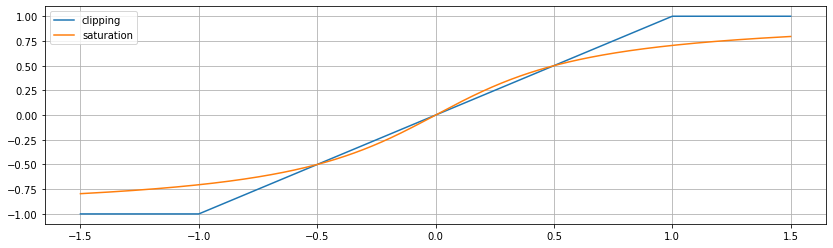

In [7]:
x = np.linspace(-1.5, 1.5, 1000)
plt.plot(x, np.clip(x, -1, 1), label="clipping")
plt.plot(x, 2 * np.arctan(2 * x) / np.pi, label="saturation");
plt.grid()
plt.legend();

### Power level: the VU meter
<img src="img/vu-meter.jpg" alt="vumeter" style="float: right; width: 200px; margin: 20px 30px;"/>

 * maximum input level: about $24~\mathrm{dBu}$ (12V RMS)
 * noise floor: at least $-90~\mathrm{dB}$ in pro equipment
 * target level for line signals: $4~\mathrm{dBu}$ (1V RMS)
 * $20~\mathrm{dB}$ **headroom**
 * distortion is progressive in headroom
 * short moments "in the red" are OK

VU meters (Volume Unit) compute the RMS via mechanical integration over approximately 300ms. They are calibrated so that zero corresponds to $4~\mathrm{dBu}$

### Peak levels: the PPM

<img src="img/ppm.jpg" alt="ppm" style="float: right; width: 200px; margin: 0px 30px;"/>


Peak Programme Meters are analog devices that monitor the amplitude of the input. 

Essentially VU meters with:
 * fast integration time (as $T\rightarrow 0, x_{\mathrm{RMS}} \rightarrow x_\mathrm{peak}$)
 * quick rise with no overshoot
 * slow release time

Because of the integration time, PPMs under-read bursts shorter than 10 ms.

### Modeling analog meters

Mechanical integration can be modeled digitally via a leaky integrator.

The needle _ballistics_ is different for VU meters and for PPMs:
 * VU meters have a long integration window and similar rise and fall dynamics
 * PPMs must rise fast but fall slowly

In [8]:
def analog_meter(x, rise, fall):
    ppm = np.r_[0, (x * x)[:-1]]
    for n in range(1, len(x)):
        a = rise if ppm[n] > ppm[n-1] else fall
        ppm[n] = a * ppm[n] + (1 - a) * ppm[n-1]
    return np.sqrt(ppm)

def vu_meter(x, c=0.001):
    return analog_meter(x, rise=c, fall=c)
                
def ppm(x, rc=0.9, fc=0.0001):
    return analog_meter(x, rise=rc, fall=fc)                

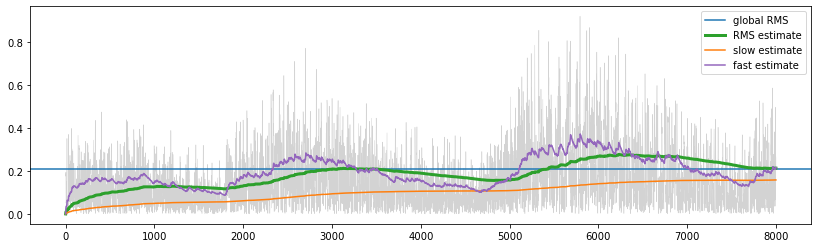

In [9]:
clip = audio_sample[8000:16000]
plt.plot(np.abs(clip), color='lightgray', linewidth=0.5)
plt.axhline(y=np.sqrt(np.mean(clip * clip)), color='C0', label='global RMS')
plt.plot(vu_meter(clip), color='C2', linewidth=3, label='RMS estimate')
plt.plot(vu_meter(clip, c=0.0001), color='C1', label='slow estimate')
plt.plot(vu_meter(clip, c=0.01), color='C4', label='fast estimate')
plt.legend();

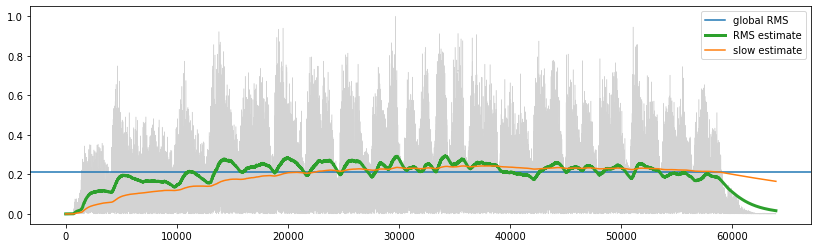

In [10]:
clip = audio_sample
plt.plot(np.abs(clip), color='lightgray', linewidth=0.5)
plt.axhline(y=np.sqrt(np.mean(clip * clip)), color='C0', label='global RMS')
plt.plot(vu_meter(clip), color='C2', linewidth=3, label='RMS estimate')
plt.plot(vu_meter(clip, c=0.0001), color='C1', label='slow estimate')
plt.legend();

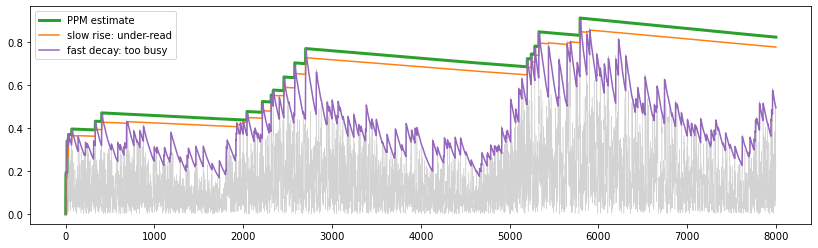

In [11]:
clip = audio_sample[8000:16000]
plt.plot(np.abs(clip), color='lightgray', linewidth=0.5)
plt.plot(ppm(clip), color='C2', linewidth=3, label='PPM estimate')
plt.plot(ppm(clip, rc=0.4), color='C1', label='slow rise: under-read')
plt.plot(ppm(clip, fc=0.01), color='C4', label='fast decay: too busy')
plt.legend();

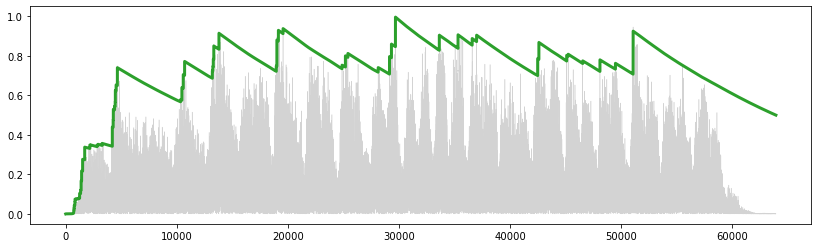

In [12]:
clip = audio_sample
plt.plot(np.abs(clip), color='lightgray', linewidth=0.5)
plt.plot(ppm(clip, fc=0.0001), color='C2', linewidth=3, label='PPM estimate');

## Digital equipment

AD converters are hard clippers; digital distortion is VERY harsh. Must remain below $0~\mathrm{dBFS}$.

A digital representation with $R$ bits per sample has a dynamic range equal to 

$$
    20 \log_{10}\frac{2^R}{1} \approx 6R~\mathrm{dB}
$$

In digital audio we must ensure that all samples are within the range of a $R$-bit word. Hence we measure the _peak_ value against the largest possible value:

$$
    L_x = 20 \log_{10}\frac{x_\mathrm{peak}}{2^R}~\mathrm{dBFS} \qquad \mbox{always $< 0$}
$$

### Peak and power levels: dBFS
<img src="img/dbfs.jpg" alt="dbfs" style="float: right; width: 500px; margin: 20px 10px;"/>

With $R$ bits per sample:
 * clipping point: $0~\mathrm{dBFS}$
 * noise floor: $2^{-R} \approx -6R~\mathrm{dBFS}$
 * common RMS target level alignment: $18~\mathrm{dBu} \rightarrow 0~\mathrm{dBFS}$ (EBU R68)
 * about 3 bits of "margin" 
 * distortion is all or nothing; no natural headroom


### True peak meters

Estimate of true peaks:
 * oversample by a factor of $N$
 * lowpass filter (FIR) with cutoff $\pi/N$
 * find max

In [13]:
def TPM(x, N=4):
    y = np.zeros(len(x) * N)
    y[::N] = x
    y = N * sp.lfilter(*sp.ellip(4, 0.1, 40, 1 / N), y)
    return 20 * np.log10(np.max(np.abs(y)) / np.max(np.abs(x)))

In [14]:
print(f'true peak: +{TPM(audio_sample):.2f} dB')

true peak: +0.24 dB


 
Exercise: prove that, for an input of the form $x[n]=\cos(\omega_0 n)$, the maximum error in true peak estimation is $20\log_{10}(\cos(\omega_0/(2N))$ 

# Perceptual measurements for recording/production

Main goal: quantify **loudness,** either for safety reasons or to adjust reproduction levels.

The complicated nature of loudness:
 * frequency-dependent (equal loudness countours)
 * sort-range time dependency (temporal masking of softer sounds after loud sounds)
 * long-range time dependency (desensitization to high levels)
 * perceptual "deafness" to irrelevant or repetitive sounds

## A-weighting and C-weighting (dBA, dBC)
<img src="img/slm.jpg" alt="sound level meter" style="float: right; width: 350px; margin: 10px 0;"/>

Used to assess the impact of environmental sounds and noise,  mostly for hearing damage risk measurements.
 * input is filtered to weigh spectrum according to perceptual impact
 * computes SPL of filtered input over user-definable window

Weighting filters:
 * **A-weighting** is based the 40-phon equal-loudness contour and it is used for moderate to low levels (40 phon is the loudness of a quiet room)
 * **C-weighting** has flatter response from 500 Hz to 2 kHz and it is used for louder levels (up to 100 dB SPL) 
 * **Z-weighting** is completely flat (no weighting)
 
The transfer function of the A and C filter responses is standardized by the IEC and the coefficients for a digital implementation can be computed via the bilinear transfotrm. The ones used here have been obtained via the package [PyFilterbank](http://siggigue.github.io/pyfilterbank).

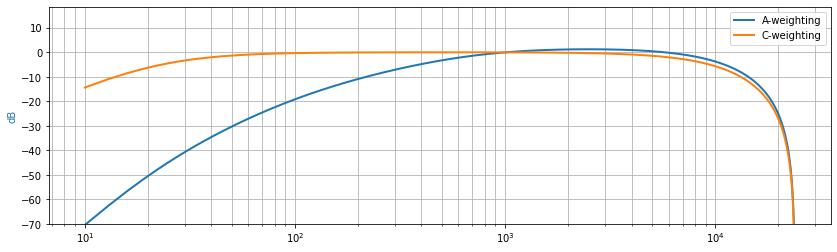

In [15]:
A_weighting = (
    np.array([ 0.234301792299513, -0.468603584599027, -0.234301792299513, 0.937207169198054, -0.234301792299513, -0.468603584599027, 0.234301792299513]), 
    np.array([ 1.               , -4.113043408775871,  6.553121752655046, -4.990849294163378, 1.785737302937571, -0.246190595319486, 0.011224250033231])
)

C_weighting = (
    np.array([ 0.197887120026393,  0.               , -0.395774240052787,        0.               ,  0.197887120026393]), 
    np.array([ 1.               , -2.2191729140528  ,  1.455135878947169,       -0.248496073887782,  0.012538823147272])
)

_, ax = plt.subplots()
analog_response(*A_weighting, sf=48000, axis=ax, color='C0')
analog_response(*C_weighting, sf=48000, axis=ax, color='C1')
ax.legend(['A-weighting','C-weighting']);

## LUFS 

Loudness Units relative to Full Scale (LUFS) is a logarithmic measure of perceived loudness computed using a psychoacoustic model of loudness perception. The algorithm has been proposed by by ITU in 2006 and the latest recommendation can be downloaded [here](https://www.itu.int/dms_pubrec/itu-r/rec/bs/R-REC-BS.1770-4-201510-I!!PDF-E.pdf).

It has become the most important metric in audio mastering, broadcast, and streaming.

### Some history: loudness = money and the "loudness wars"

People (apparently) prefer music that sounds loud. How do you make your track sound louder than the competition on the radio? 

Historically, broadcasters mandated a maximum _peak_ level for tracks. But loudness is related to RMS.

You can keep the same peak and increase the RMS via **compression and limiting**, which reduces PAPR.

Think of square wave vs sine wave

<img src="img/waveforms.png" alt="wikipedia" style="width: 600px;"/>

<img src="img/loudnesswar.jpg" alt="wikipedia" style="float: right; width: 300px; margin: 0px 20px;"/>

The **loudness wars** started in the 1990s; both new album and remasters tried to minimize the PAPR. Consequences:
 * loss of dynamic range (everything sounds "squished")
 * loss of definition (ear fatigue due to almost constant RMS)
 
PAPR minimization was a loophole because broadcasters used to set limits on peak levels instead of limiting loudness.

A reliable "loudness meter" was needed to close the loophole: LUFS

Other example: loud commercial breaks on TV. Annoying and illegal!

 * EBU R 128, 2012
 * US CALM act, 2012

These rulings can be enforced because of LUFS

<img src="img/loudnessBA.png" alt="wikipedia" style="float: right; width: 400px; margin: 0px 0px;"/>

How Spotify (& Co) ended the loudness wars: "loud" tracks are scaled down until they are below a set LUFS value:

|  |  |
|--|--|
|Spotify | -14 LUFS |
|Apple Music | -16 LUFS |
|Youtube | -14 LUFS |
|TV/Radio | -23 LUFS |

Tracks mastered for maximum loudness will be played at a lower volume: dynamic range has been sacrificed for nothing

### LUFS metrics

 * **LUFS M** (momentary max): momentary (peak) loudness (400 ms)
 * **LUFS S** (short term): averaged loudness over 3 seconds
 * **LUFS integrated**:  averaged loudness for the entire track/movie/program
 
Broadcast and streaming plaform adjust for LUFS integrated.

### The algorithm

<img src="img/lufsbd.jpg" alt="EBU" style="width: 800px;"/>


#### K-filter
  * high shelf pre filter (head model)
  * highpass filter (a bit like A-weighting)
  * net result: eliminate frequencies below 37 Hz and boost everything over 1.5 kHz by 4 dB

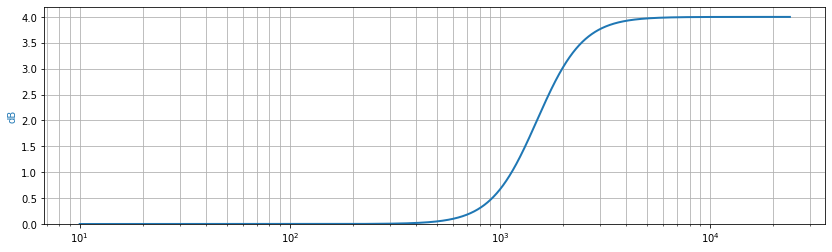

In [16]:
b, a = [1.53512485958697, -2.69169618940638, 1.19839281085285], [1.0, -1.69065929318241, 0.73248077421585]
analog_response(b, a, sf=48000)

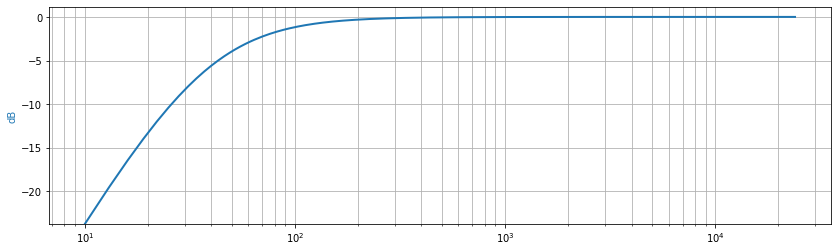

In [17]:
b, a = [1.0, -2.0, 1.0], [1.0, -1.99004745483398, 0.99007225036621]
analog_response(b, a, sf=48000)

#### Two-step gating

For long integration intervals, quiet or silent intervals would result in a meaningless reduction of the overall loudness. To avoid this:

 * RMS values are computed over overlapping 400 ms intervals
 * intervals below -70 dB are discarded
 * threshold $\Gamma_r$ is average of surviving blocks
 * program loudness is average of blocks where RMS >  $\Gamma_r$ - 10 dB

### Target levels for mastering

|  |  |
|--|--|
|CD | -9 LUFS |
|EDM/club tracks | -6 LUFS |
| Vinyl | -20 to -16 LUFS |



### Sample implementation

This straightforward implementation computes the three LUFS metrics for a monophonic signal at an arbitrary sampling rate:

In [37]:
def LUFS(x, sf):
    """simple, single channel implementation of a LUFS meter"""
    # compute the filter coefficients for the given sampling rate:    
    #  1) pre-filter: 4 dB gain high shelf, crossover @ 1.5 kHz
    w, A = 2 * np.pi * (1500.0 / sf), 10 ** (4.0 / 40)
    c, d = np.cos(w), np.sqrt(2 * A) * np.sin(w)
    pb = A * np.array([((A + 1) + (A - 1) * c + d), -2 * ((A - 1) + (A + 1) * c), ((A + 1) + (A - 1) * c - d)])
    pa = np.array([(A + 1) - (A - 1) * c + d, 2 * ((A - 1) - (A + 1) * c), (A + 1) - (A - 1) * c - d])
    #  2) weighting filter: highpass, 40 Hz cutoff, Q = 1/2, double zero at pi
    w = 2 * np.pi * (40.0 / sf)
    wb = np.array([1, -2, 1])
    wa = np.array([1 + np.sin(w), -2 * np.cos(w), 1 - np.sin(w)])
    
    C = 10 ** (-0.691 / 10)  # -0.691 dB adjustment as per specs
    y = C * np.square(sp.lfilter(wb, wa, sp.lfilter(pb, pa, x)))
    
    # compute RMS for each block
    step = int(sf * 0.100)  # analysis blocks are 400 ms, with 75% overlap, so step is 100 ms
    block_size = 4 * step   
    z = np.zeros(len(x) // step)
    for n in range(0, len(z)):
        z[n] = np.mean(y[(n * step):(n * step + block_size)])
    
    # momentary LUFS (every 400 ms, no gate)
    lufs_m = z[::4]
    # short-term LUFS (avg over 3s, no gate)
    lufs_s = np.array([np.mean(s) for s in np.split(z, range(30, len(z), 30))])
    # integrated LUFS: compute the data-dependent threshold
    gamma_r = np.mean(z[z > 0.0000001]) / 10  # kill everything under -70 dB
    lufs_i = np.mean(z[z > gamma_r])
    
    return 10 * np.log10(lufs_m), 10 * np.log10(lufs_s), 10 * np.log10(lufs_i)

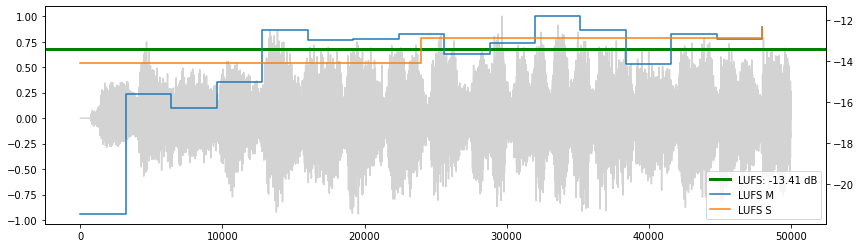

In [38]:
clip = audio_sample[:50000]
lufs_m, lufs_s, lufs = LUFS(clip, audio_sample_sf)

_, ax1 = plt.subplots()
ax1.plot(clip, color='lightgray');
ax2 = ax1.twinx()
ax2.axhline(y=lufs, color='green', linewidth=3, label=f'LUFS: {lufs:.2f} dB')
ax2.step(np.arange(0, len(lufs_m)) * audio_sample_sf * 0.4, lufs_m, where='post', label='LUFS M')
ax2.step(np.arange(0, len(lufs_s)) * audio_sample_sf * 3, lufs_s, where='post', label='LUFS S')
plt.legend();